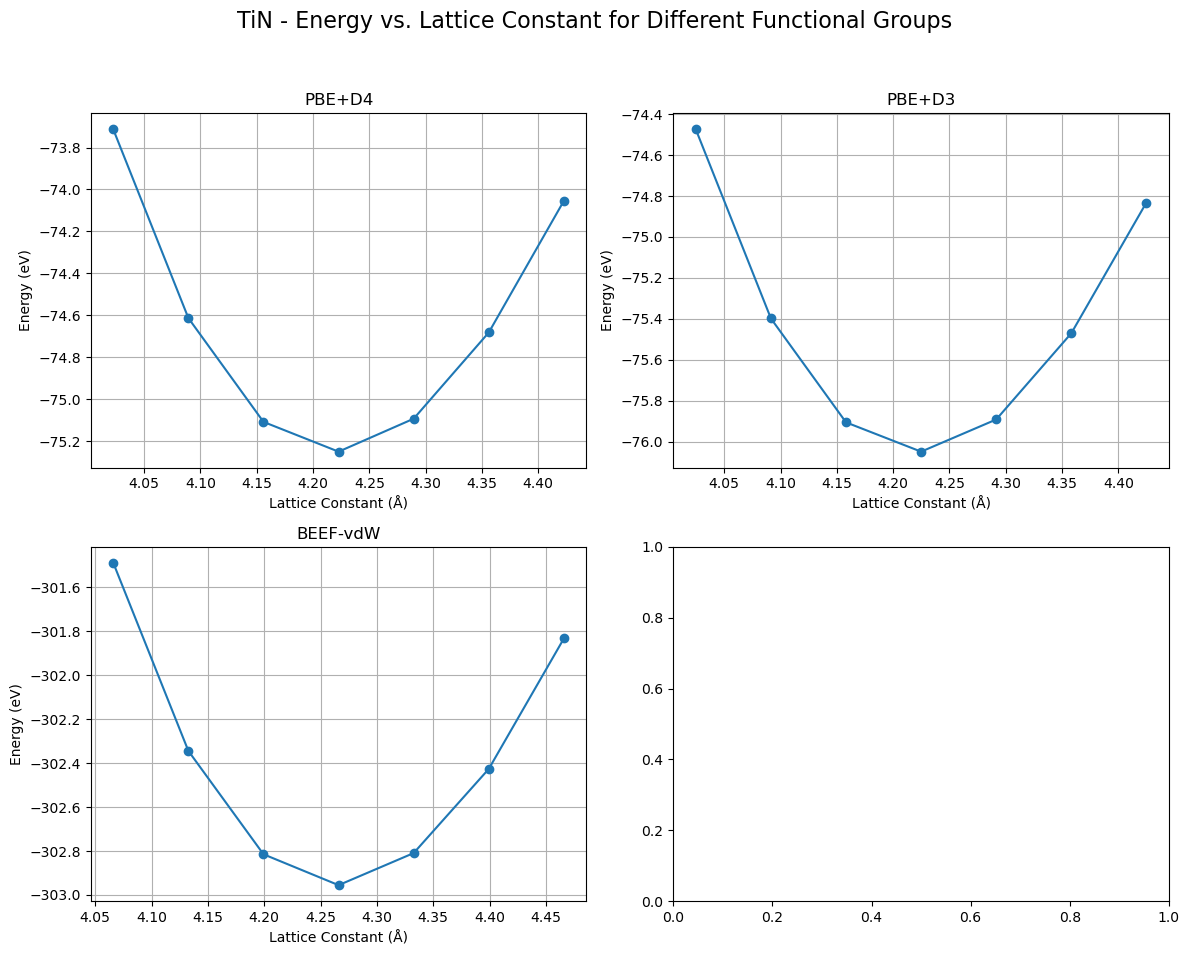

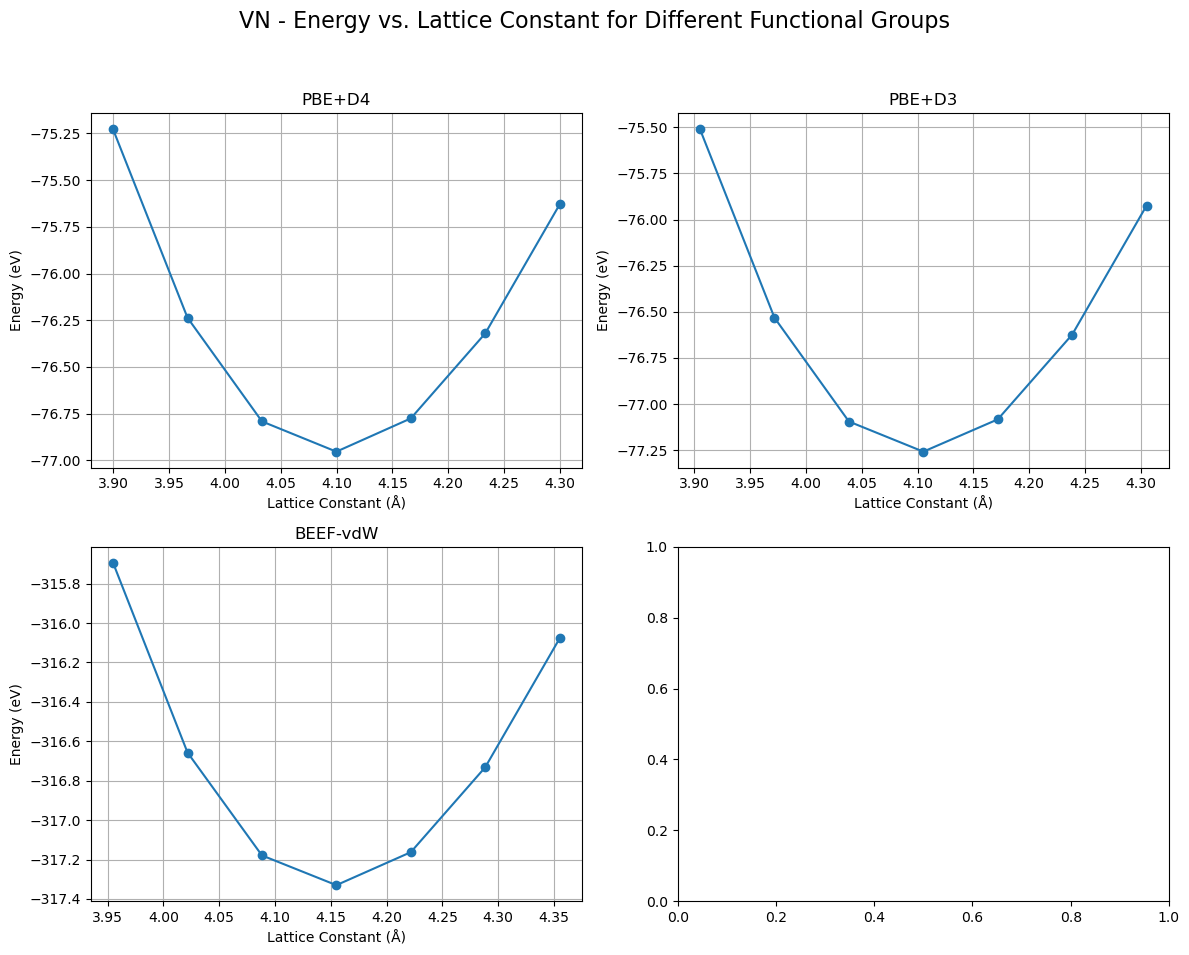

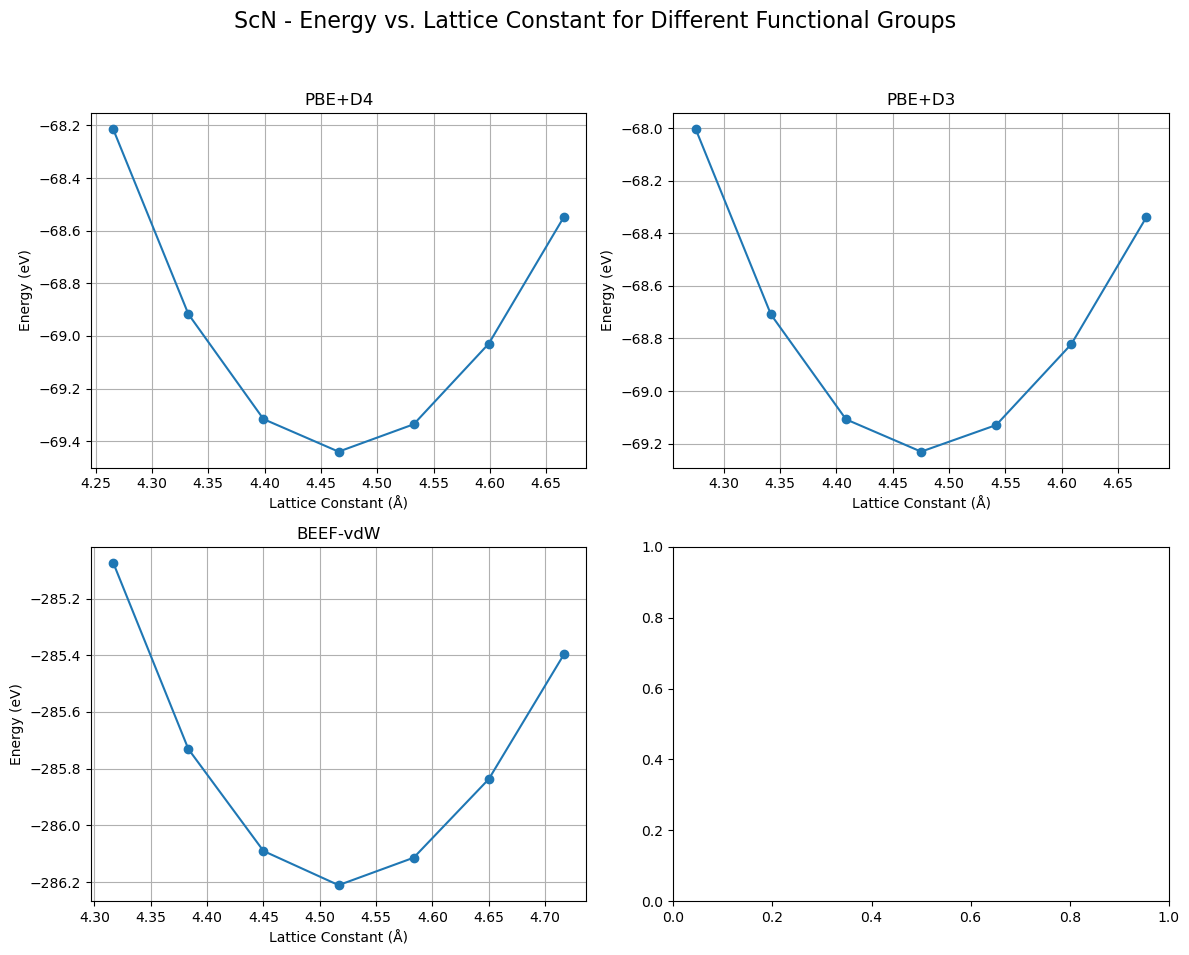

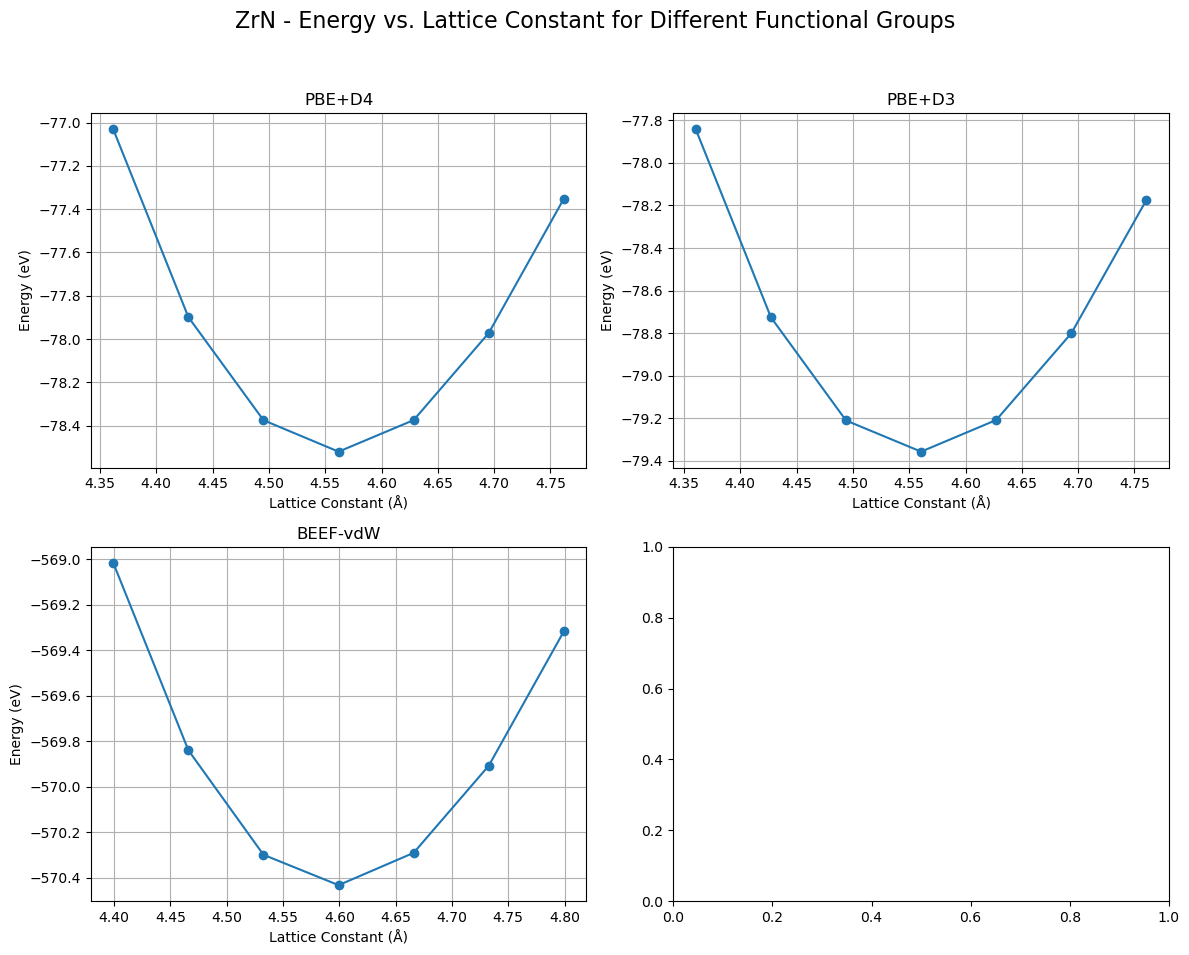

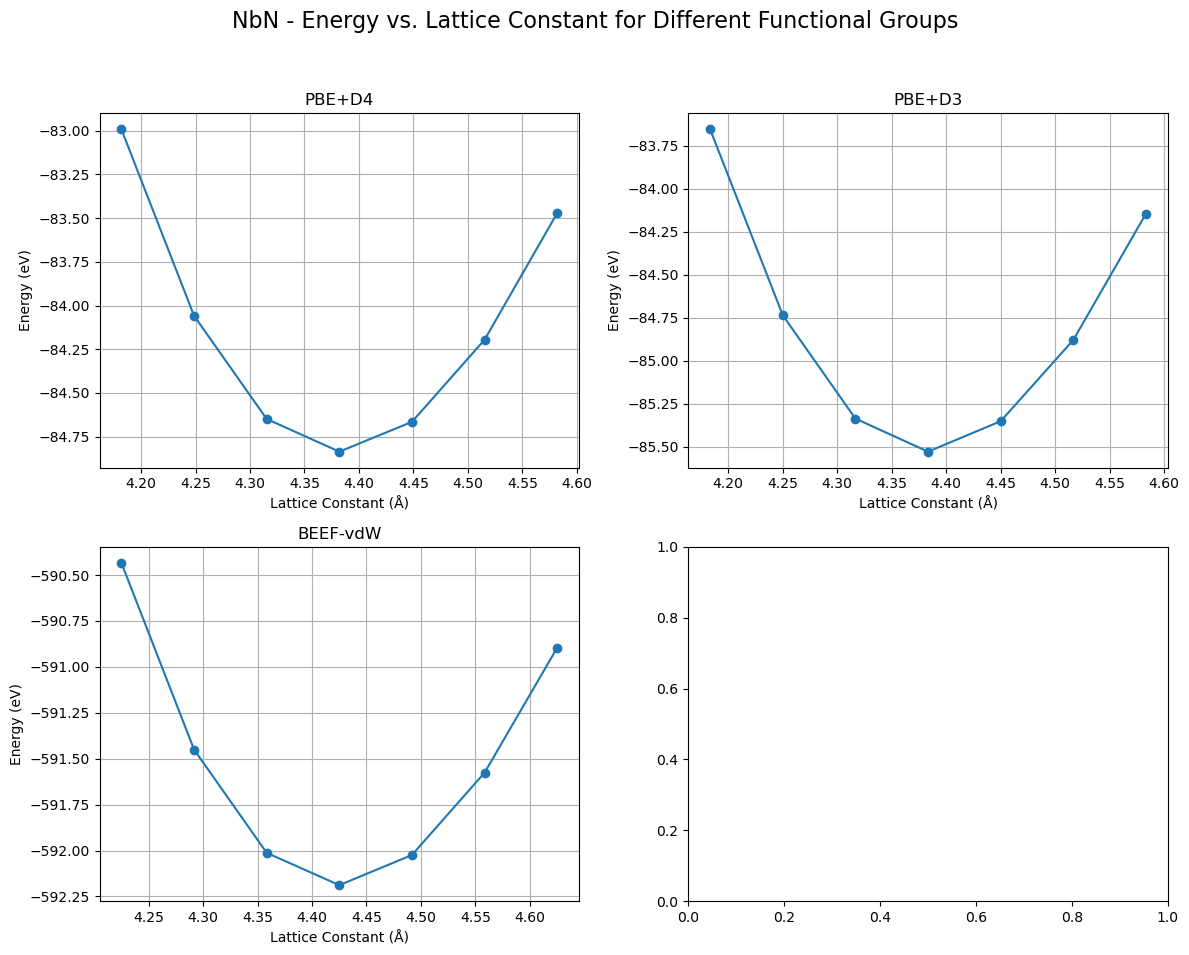

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# List your 4 CSV files here
csv_files = ['pbe_d4_results.csv', 'pbe_d3_results.csv', 'beef_vdw_results.csv']

# Read and concatenate all data
dfs = [pd.read_csv(f) for f in csv_files]
data = pd.concat(dfs, ignore_index=True)

# Get unique materials (metals in your case)
unique_materials = data['Material'].unique()

# Get unique functional groups
unique_functional_groups = data['Functional'].unique()

# Plot for each material
for mat in unique_materials:
    # Create a figure and a set of subplots for the current material
    # We'll use 2x2 grid for 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{mat} - Energy vs. Lattice Constant for Different Functional Groups', fontsize=16)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate through unique functional groups and plot on subplots
    for i, func in enumerate(unique_functional_groups):
        subset = data[(data['Material'] == mat) & (data['Functional'] == func)]

        # Check if there's data for this material and functional group
        if not subset.empty:
            axes[i].plot(subset['Lattice_Constant'], subset['Energy'], marker='o', linestyle='-')
            axes[i].set_xlabel('Lattice Constant (Å)')
            axes[i].set_ylabel('Energy (eV)')
            axes[i].set_title(f'{func}')
            axes[i].grid(True)
        else:
            # If no data, you might want to hide the subplot or add a placeholder text
            axes[i].set_visible(False) # Hides the subplot if no data

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

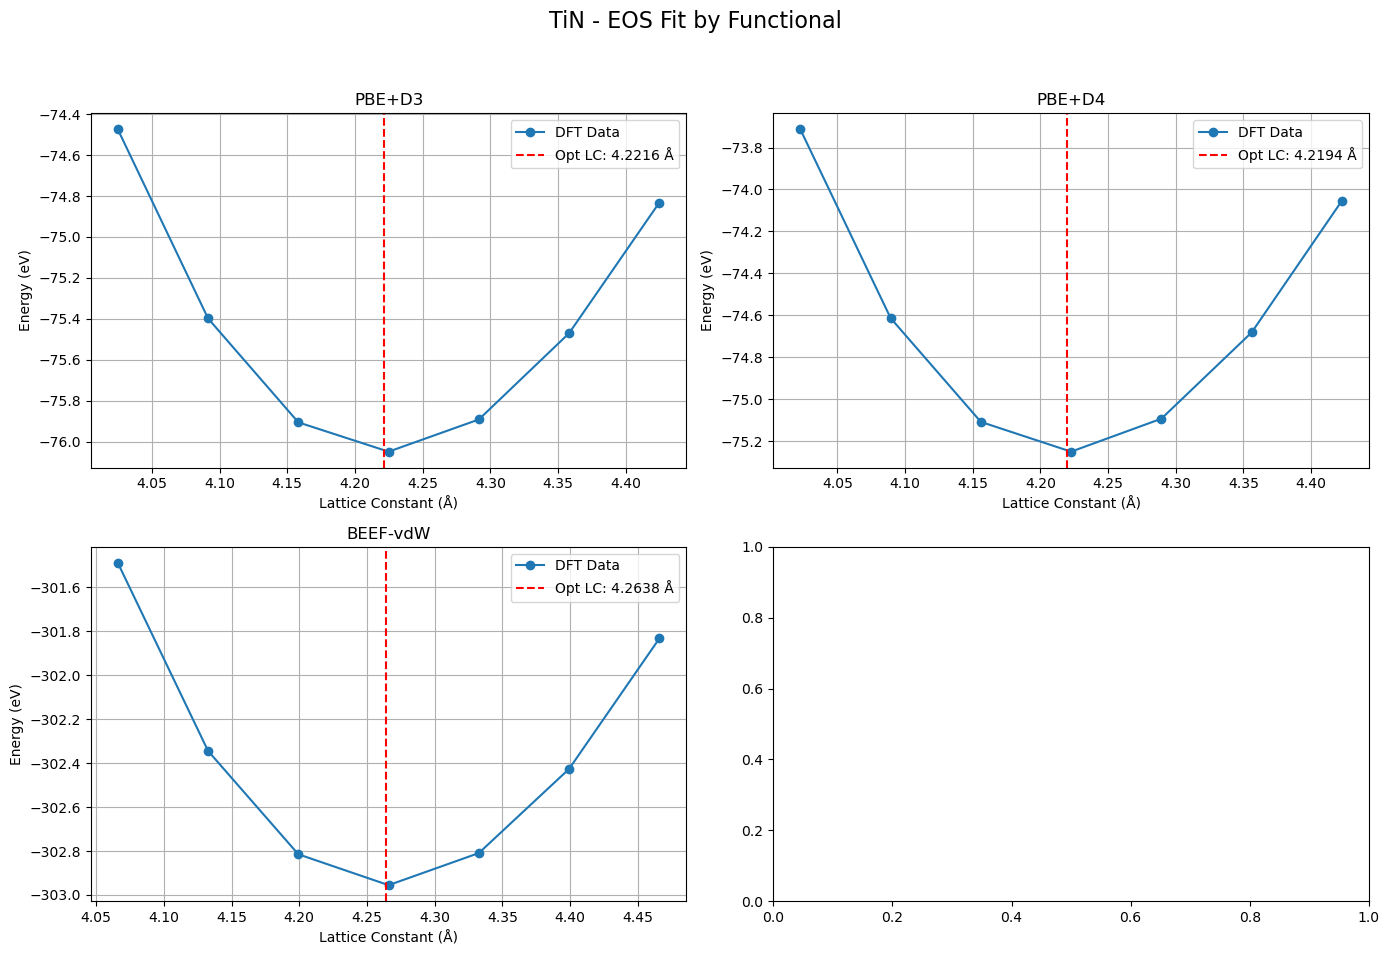

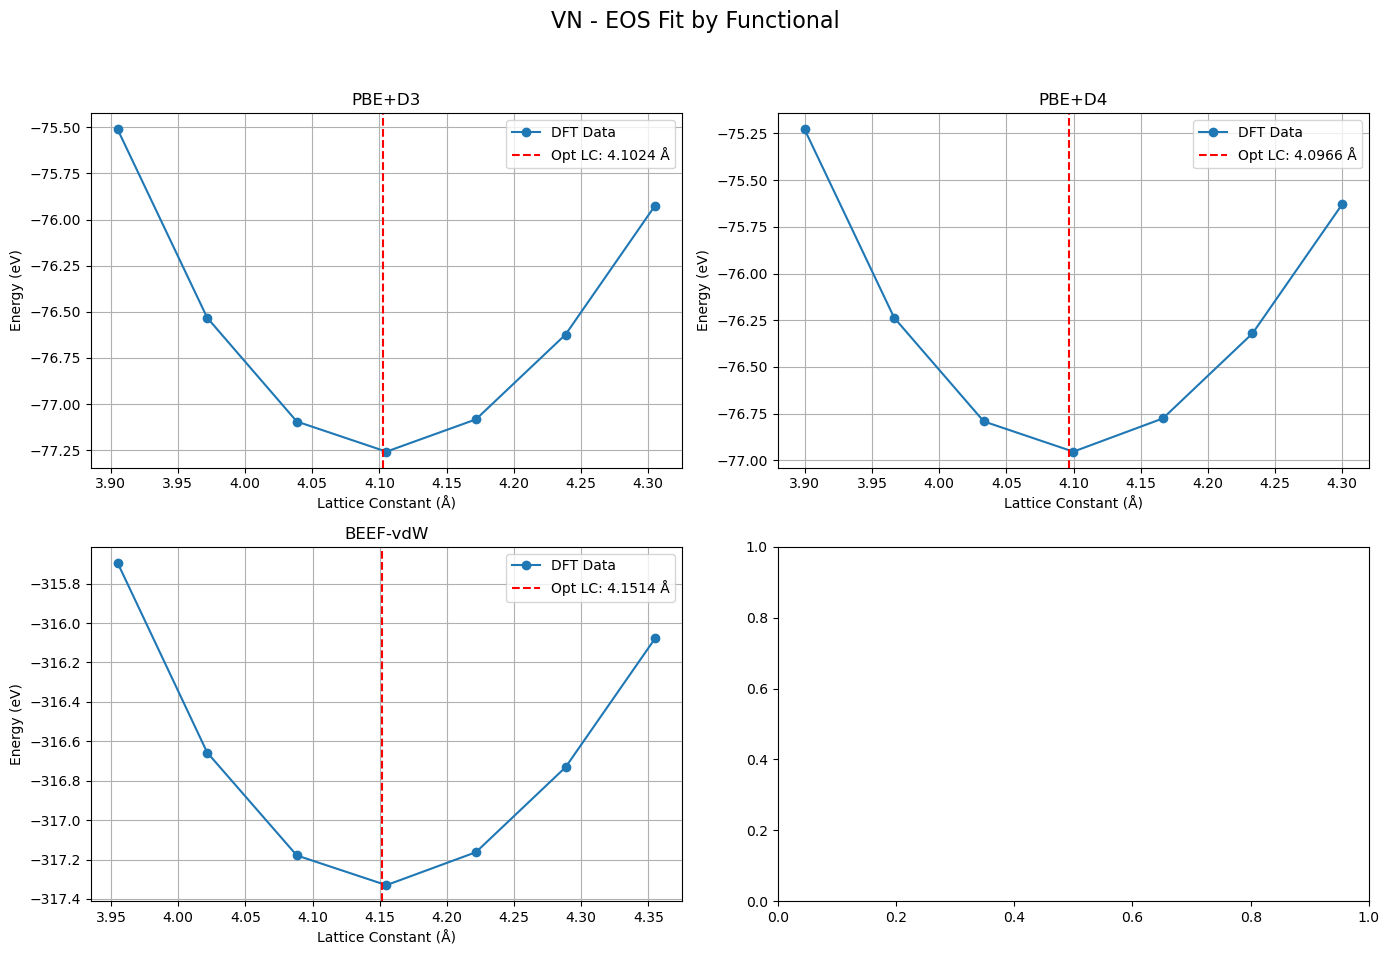

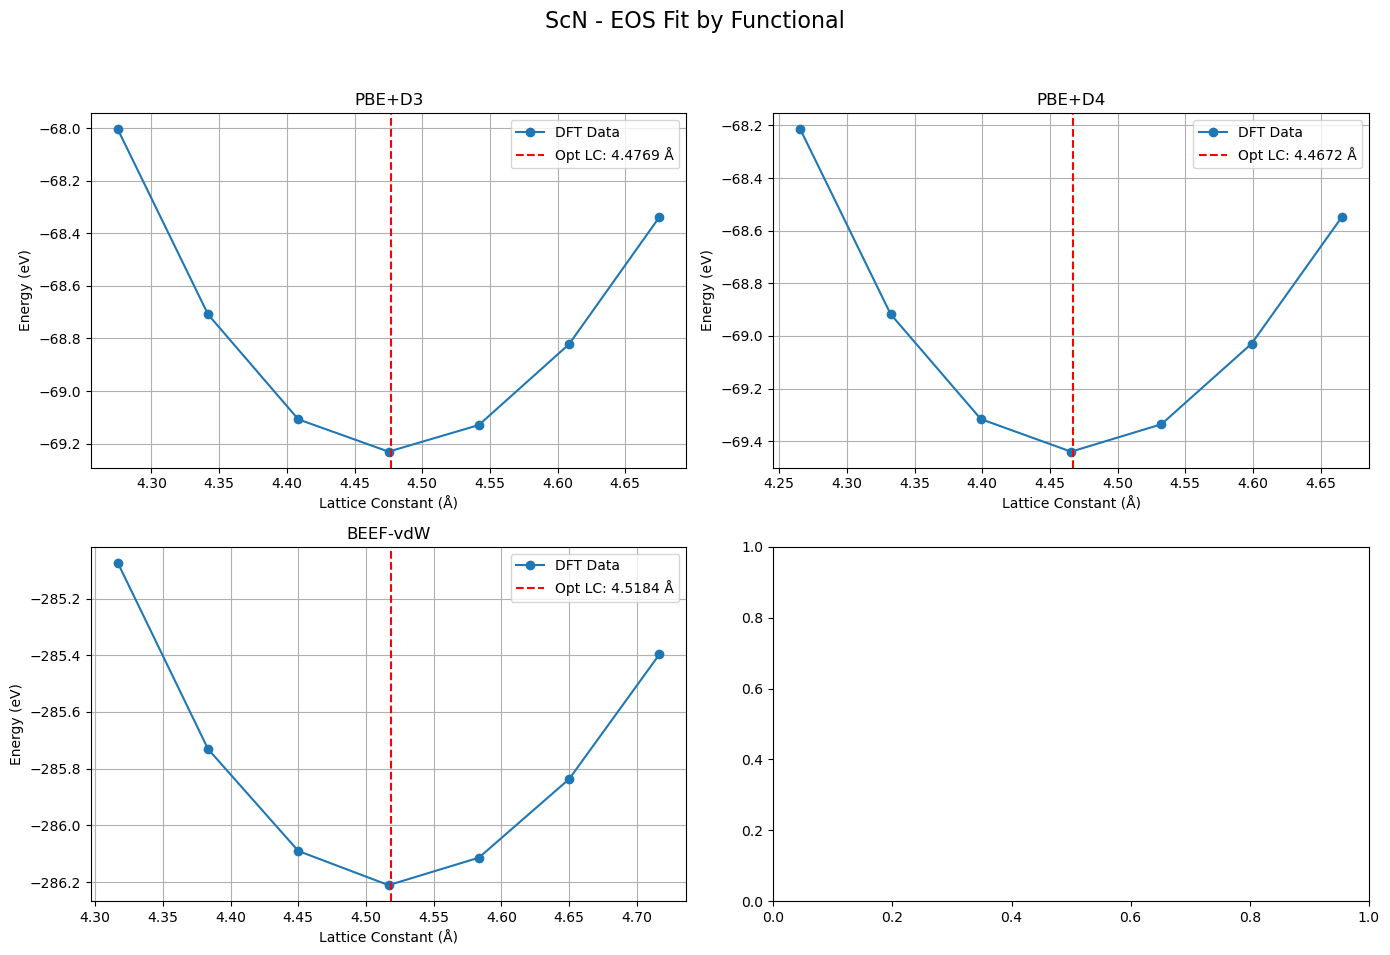

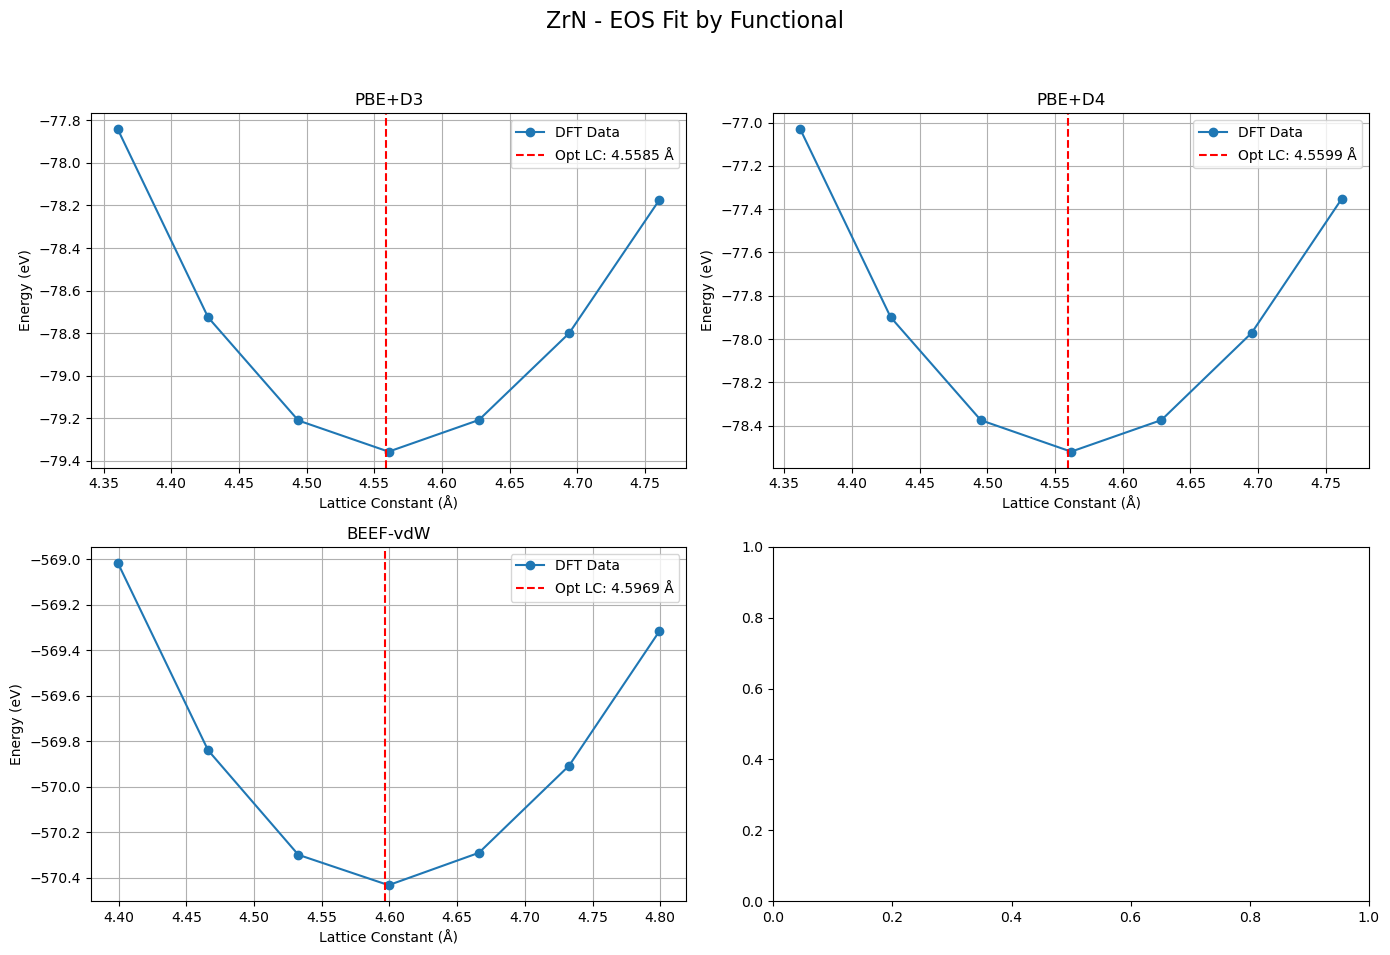

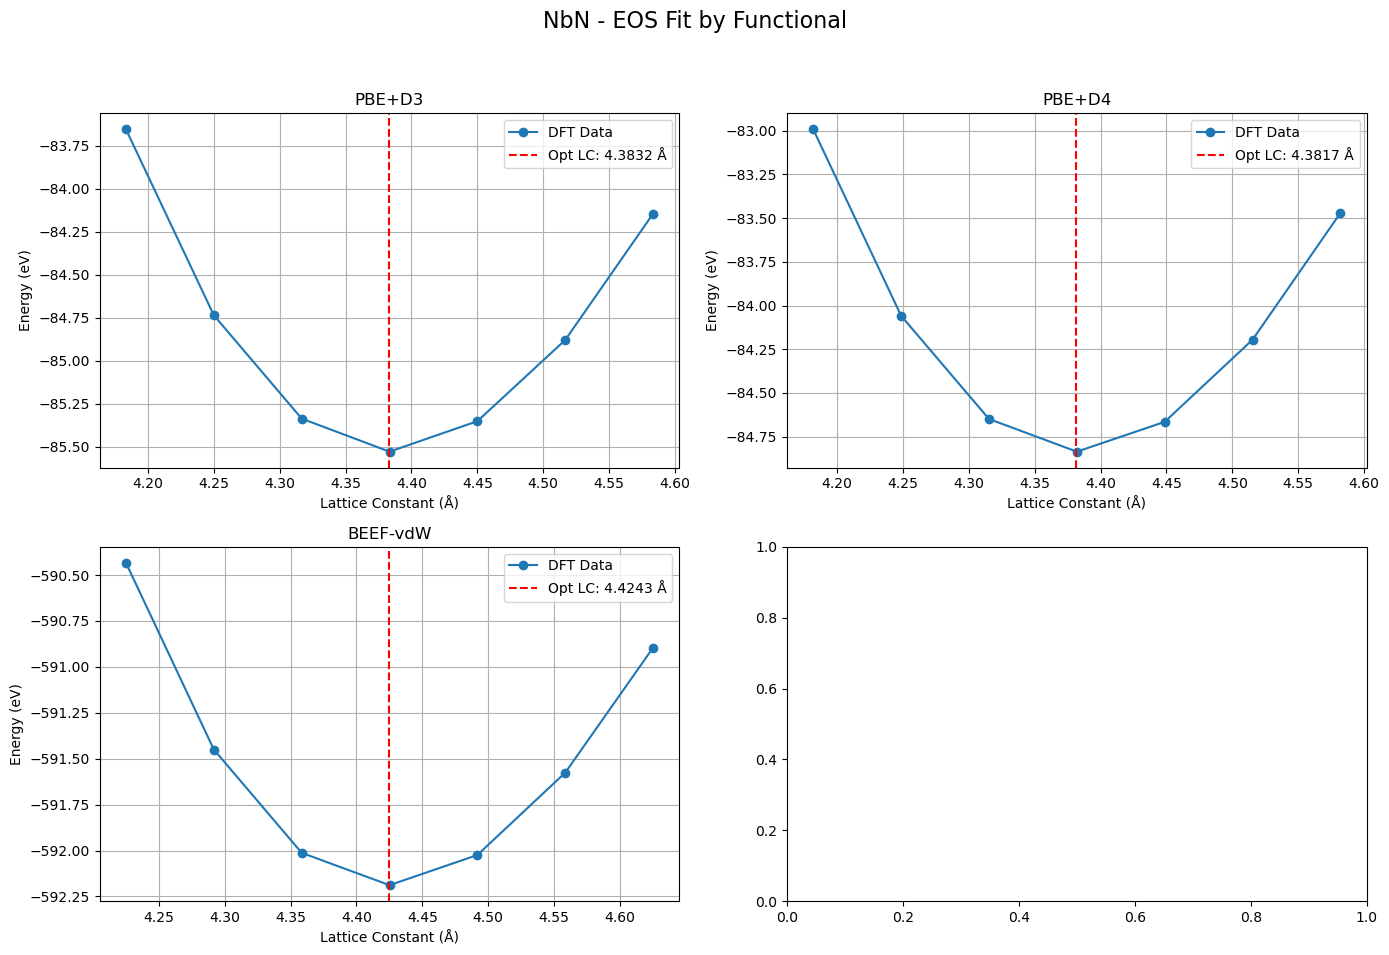


--- EOS Fit Summary ---
Material Functional  Equilibrium_Lattice_Constant  Equilibrium_Volume  Minimum_Energy  Bulk_Modulus
     TiN     PBE+D3                      4.221550           75.234299      -76.050950      1.823964
     TiN     PBE+D4                      4.219417           75.120288      -75.251040      1.785420
     TiN   BEEF-vdW                      4.263763           77.513810     -302.954904      1.668377
      VN     PBE+D3                      4.102372           69.040697      -77.257394      2.064605
      VN     PBE+D4                      4.096623           68.750843      -76.950987      2.045395
      VN   BEEF-vdW                      4.151353           71.543300     -317.329742      1.914618
     ScN     PBE+D3                      4.476851           89.725897      -69.233669      1.296144
     ScN     PBE+D4                      4.467222           89.148232      -69.441293      1.296556
     ScN   BEEF-vdW                      4.518384           92.246390     -

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ase.eos import EquationOfState

# Load your data files
dfs = {
    'PBE+D3': pd.read_csv('pbe_d3_results.csv'),
    'PBE+D4': pd.read_csv('pbe_d4_results.csv'),
    'BEEF-vdW': pd.read_csv('beef_vdw_results.csv')
}

materials = ['TiN', 'VN', 'ScN', 'ZrN', 'NbN']
eos_summary = []

for material in materials:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{material} - EOS Fit by Functional', fontsize=16)

    for ax, (functional, df) in zip(axes.ravel(), dfs.items()):
        data = df[df['Material'] == material]
        if data.empty:
            ax.set_title(f'{functional} - No Data')
            ax.axis('off')
            continue

        lattice_constants = data['Lattice_Constant'].values
        energies = data['Energy'].values
        volumes = lattice_constants ** 3

        try:
            eos = EquationOfState(volumes, energies)
            v0, e0, B = eos.fit()
            lc_eq = v0 ** (1 / 3)

            ax.plot(lattice_constants, energies, 'o-', label='DFT Data')
            ax.axvline(lc_eq, color='r', linestyle='--', label=f'Opt LC: {lc_eq:.4f} Å')
            ax.set_title(f'{functional}')
            ax.set_xlabel('Lattice Constant (Å)')
            ax.set_ylabel('Energy (eV)')
            ax.legend()
            ax.grid(True)

            eos_summary.append({
                'Material': material,
                'Functional': functional,
                'Equilibrium_Lattice_Constant': lc_eq,
                'Equilibrium_Volume': v0,
                'Minimum_Energy': e0,
                'Bulk_Modulus': B
            })
        except Exception as e:
            ax.set_title(f'{functional} - EOS Fit Failed')
            ax.text(0.5, 0.5, str(e), ha='center', va='center')
            ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Print EOS fit summary
summary_df = pd.DataFrame(eos_summary)
print("\n--- EOS Fit Summary ---")
print(summary_df.to_string(index=False))

# Optional: save the summary to CSV
# summary_df.to_csv('eos_fit_summary.csv', index=False)


In [17]:
from ase.io import read, write
import os

# Optimized lattice constants (skipping PBE)
lattice_constants = {
    'TiN': {'D3': 4.224825, 'D4': 4.222713, 'BEEF': 4.265981},
    'VN': {'D3': 4.105173, 'D4': 4.099841, 'BEEF': 4.154965},
    'ScN': {'D3': 4.475153, 'D4': 4.465668, 'BEEF': 4.516714},
    'ZrN': {'D3': 4.560577, 'D4': 4.561882, 'BEEF': 4.599342},
    'NbN': {'D3': 4.383374, 'D4': 4.381987, 'BEEF': 4.425092}
}

def rescale_and_save(metal, functional_short, new_lc):
    cif_file = f'{metal}.cif'
    if not os.path.exists(cif_file):
        print(f"Missing CIF file: {cif_file}")
        return

    atoms = read(cif_file)
    a0 = atoms.get_cell_lengths_and_angles()[0]
    scale = new_lc / a0

    atoms_new = atoms.copy()
    atoms_new.set_cell(atoms.get_cell() * scale, scale_atoms=True)

    outname = f"{metal}_{functional_short}"
    write(f"{outname}.xyz", atoms_new)
    write(f"{outname}.cif", atoms_new)
    print(f"Saved {outname}.xyz and {outname}.cif with LC = {new_lc:.4f} Å")

# Process each material and functional
for metal, func_lc in lattice_constants.items():
    for func_clean, lc in func_lc.items():
        rescale_and_save(metal, func_clean, lc)


Saved TiN_D3.xyz and TiN_D3.cif with LC = 4.2248 Å
Saved TiN_D4.xyz and TiN_D4.cif with LC = 4.2227 Å
Saved TiN_BEEF.xyz and TiN_BEEF.cif with LC = 4.2660 Å
Saved VN_D3.xyz and VN_D3.cif with LC = 4.1052 Å
Saved VN_D4.xyz and VN_D4.cif with LC = 4.0998 Å
Saved VN_BEEF.xyz and VN_BEEF.cif with LC = 4.1550 Å
Saved ScN_D3.xyz and ScN_D3.cif with LC = 4.4752 Å
Saved ScN_D4.xyz and ScN_D4.cif with LC = 4.4657 Å
Saved ScN_BEEF.xyz and ScN_BEEF.cif with LC = 4.5167 Å
Saved ZrN_D3.xyz and ZrN_D3.cif with LC = 4.5606 Å
Saved ZrN_D4.xyz and ZrN_D4.cif with LC = 4.5619 Å
Saved ZrN_BEEF.xyz and ZrN_BEEF.cif with LC = 4.5993 Å
Saved NbN_D3.xyz and NbN_D3.cif with LC = 4.3834 Å
Saved NbN_D4.xyz and NbN_D4.cif with LC = 4.3820 Å
Saved NbN_BEEF.xyz and NbN_BEEF.cif with LC = 4.4251 Å


/tmp/ipykernel_7350/1151003096.py:20: DeprecationWarning: Please use atoms.cell.cellpar() instead
  a0 = atoms.get_cell_lengths_and_angles()[0]


In [9]:
from ase.io import read
from ase.visualize import view
view(read('VN_PBE+D4_best.xyz'))
view(read('VN_BEEF-vdW_best.xyz'))
view(read('VN_PBE+D3_best.xyz'))

<Popen: returncode: None args: ['c:\\Users\\ameer\\miniforge3\\envs\\ase\\py...>

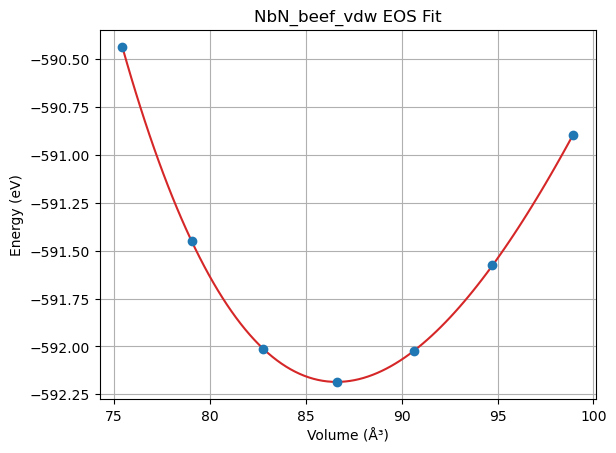

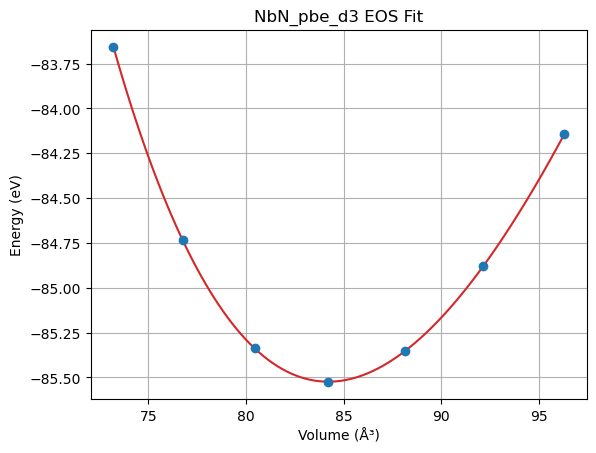

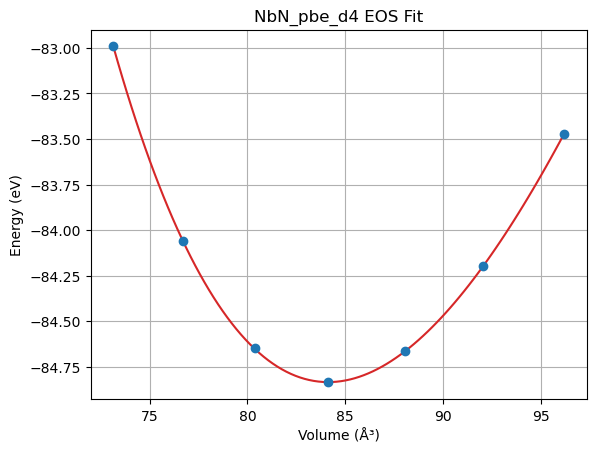

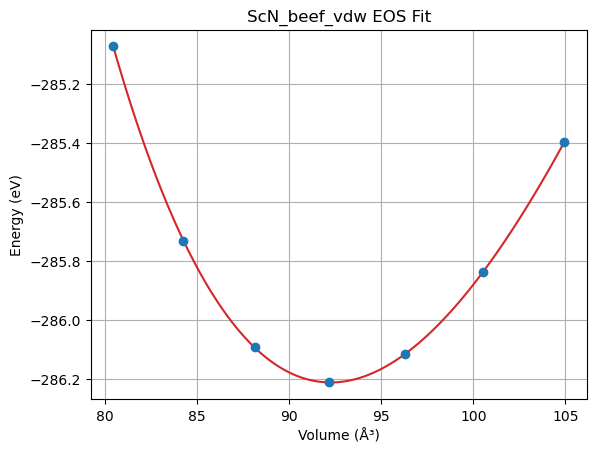

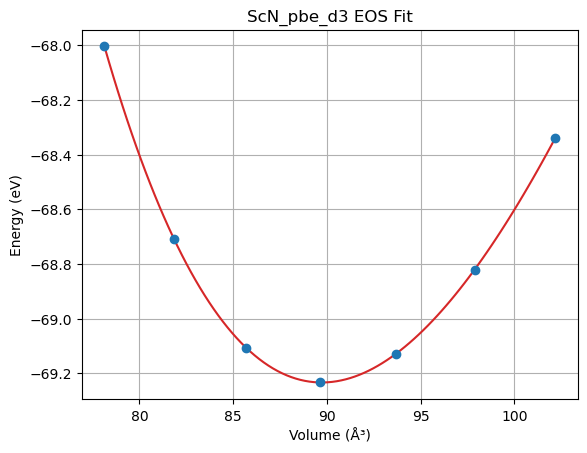

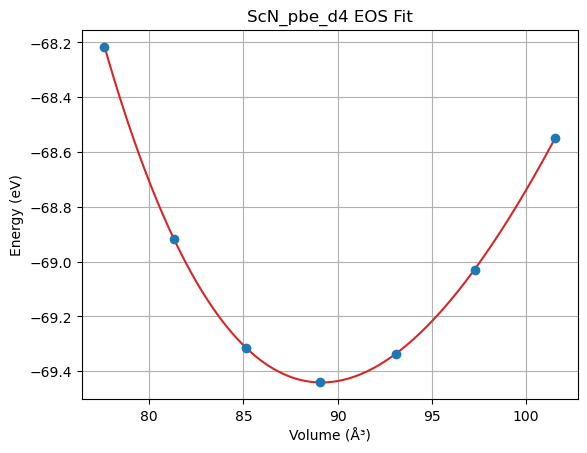

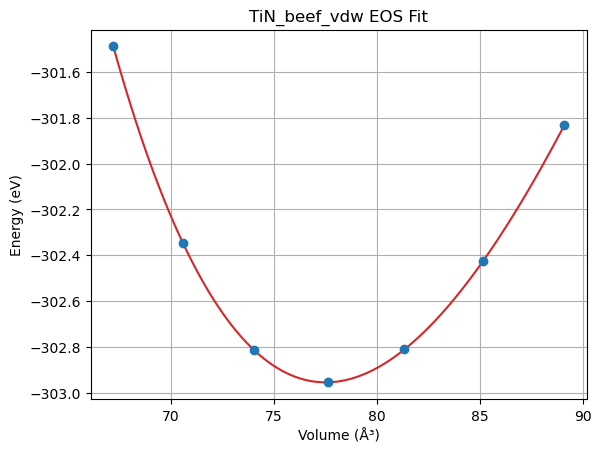

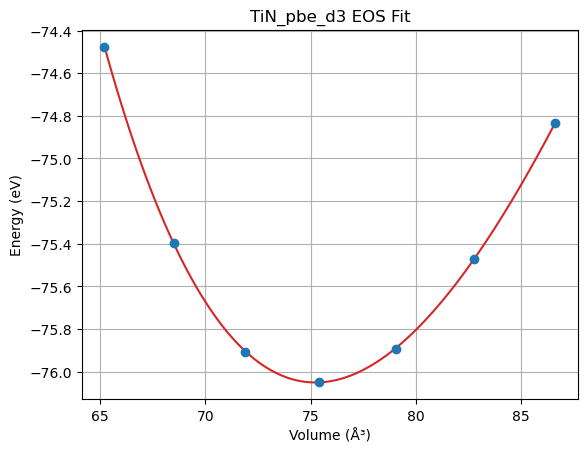

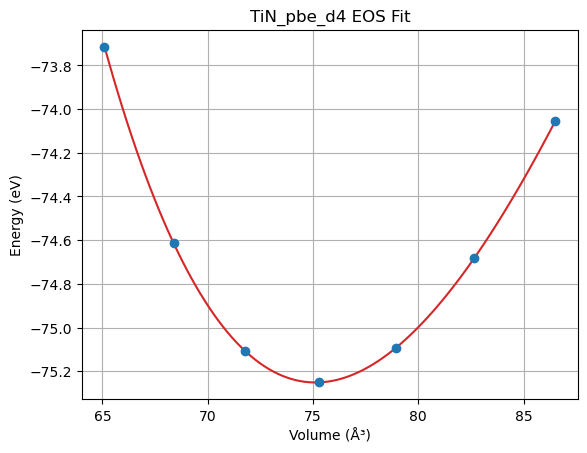

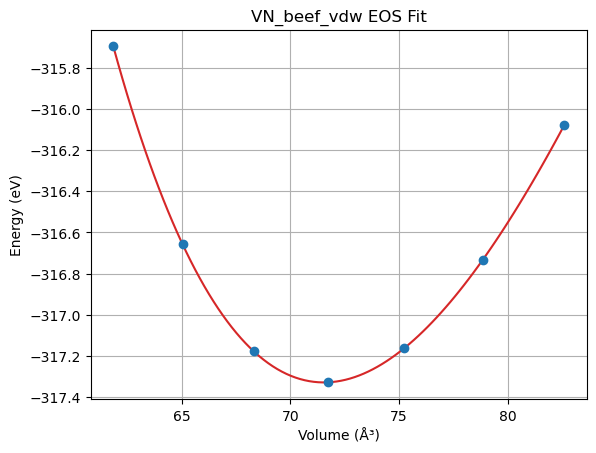

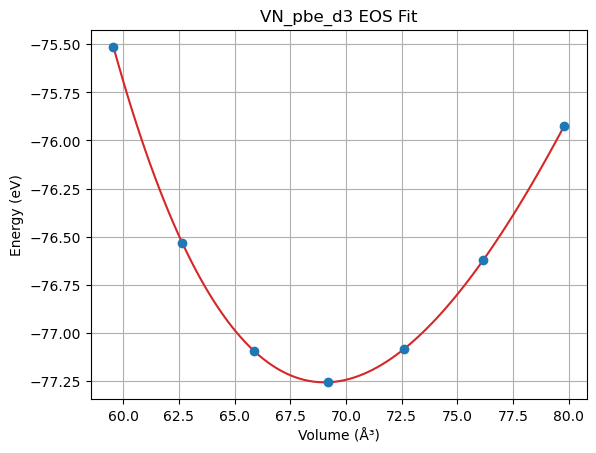

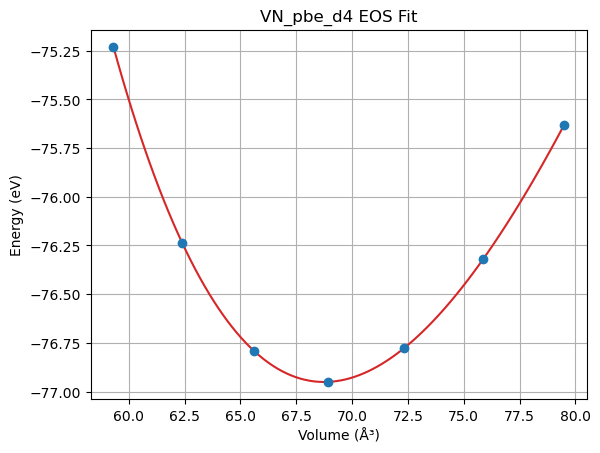

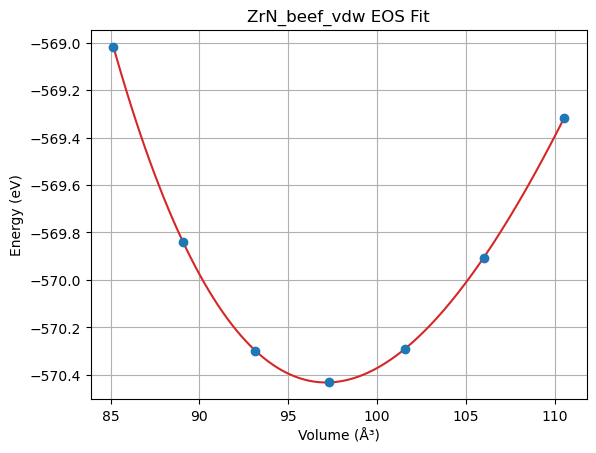

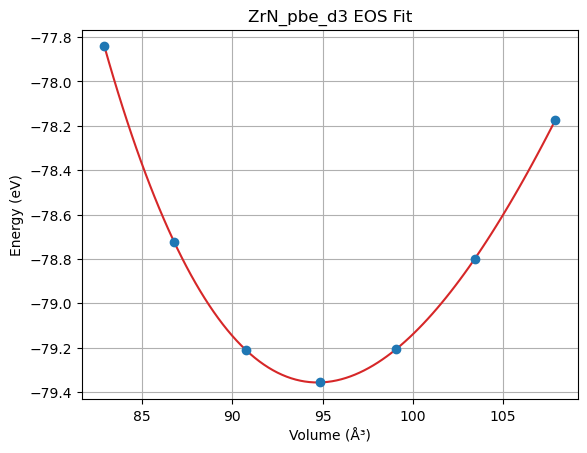

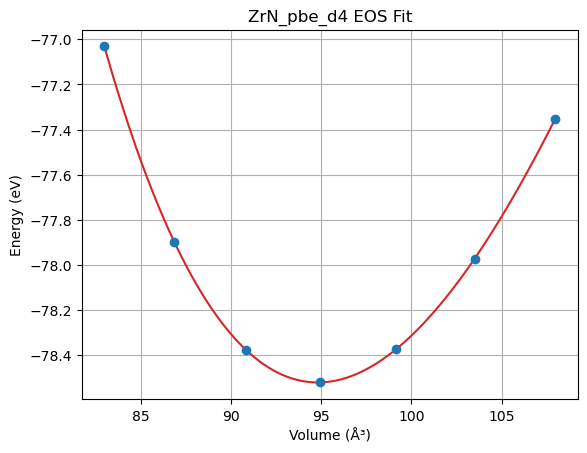

      System  LC_eq (Å)  Volume_eq (Å³)  E_min (eV)  Bulk Modulus (eV/Å³)
NbN_beef_vdw   4.424326       86.604650 -592.185617              1.884493
  NbN_pbe_d3   4.383211       84.212596  -85.523611              2.029242
  NbN_pbe_d4   4.381731       84.127325  -84.834651              2.004747
ScN_beef_vdw   4.518384       92.246390 -286.211113              1.176677
  ScN_pbe_d3   4.476851       89.725897  -69.233669              1.296144
  ScN_pbe_d4   4.467222       89.148232  -69.441293              1.296556
TiN_beef_vdw   4.263763       77.513810 -302.954904              1.668377
  TiN_pbe_d3   4.221550       75.234299  -76.050950              1.823964
  TiN_pbe_d4   4.219417       75.120288  -75.251040              1.785420
 VN_beef_vdw   4.151353       71.543300 -317.329742              1.914618
   VN_pbe_d3   4.102372       69.040697  -77.257394              2.064605
   VN_pbe_d4   4.096623       68.750843  -76.950987              2.045395
ZrN_beef_vdw   4.596924       97.14089

In [11]:
from ase.io import Trajectory
from ase.eos import EquationOfState
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Directory containing .traj files
traj_dir = './'  # or adjust to your location
traj_files = [f for f in os.listdir(traj_dir) if f.endswith('.traj')]
eos_results = []

for fname in traj_files:
    try:
        traj = Trajectory(os.path.join(traj_dir, fname))
        volumes = [atoms.get_volume() for atoms in traj]
        energies = [atoms.get_potential_energy() for atoms in traj]

        eos = EquationOfState(volumes, energies)
        v0, e0, B = eos.fit()
        lc_eq = v0 ** (1/3)

        label = fname.replace('_lc_scan.traj', '')
        eos_results.append((label, lc_eq, v0, e0, B))

        # Plot
        plt.figure()
        eos.plot()
        plt.title(f'{label} EOS Fit')
        plt.xlabel('Volume (Å³)')
        plt.ylabel('Energy (eV)')
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"⚠️ Error with {fname}: {e}")

# Summary table
df = pd.DataFrame(eos_results, columns=['System', 'LC_eq (Å)', 'Volume_eq (Å³)', 'E_min (eV)', 'Bulk Modulus (eV/Å³)'])
print(df.to_string(index=False))


In [12]:
import os
from ase.io import read, write
from ase import Atoms
import numpy as np

input_dir = '.'  # Use current directory if running from inside 'crystal'
output_dir = os.path.join(input_dir, 'sorted')
os.makedirs(output_dir, exist_ok=True)

# Helper: detect metal
def detect_metal(filename):
    name = os.path.basename(filename)
    for metal in ['Ti', 'Sc', 'Zr', 'Nb', 'V']:
        if metal in name:
            return metal
    raise ValueError(f"Cannot detect metal in filename: {filename}")

# Canonicalization function
def canonicalize_nitrogens(input_file, output_file, metal_symbol):
    atoms = read(input_file)
    frac_positions = atoms.get_scaled_positions()

    metal_atoms = []
    nitrogen_atoms = []

    for i, atom in enumerate(atoms):
        pos_frac = frac_positions[i]
        if atom.symbol == metal_symbol:
            metal_atoms.append((atom, pos_frac))
        elif atom.symbol == 'N':
            nitrogen_atoms.append((atom, pos_frac))

    nitrogen_atoms_sorted = sorted(nitrogen_atoms, key=lambda x: tuple(np.round(x[1], 6)))
    final_atoms = [ma[0] for ma in metal_atoms] + [na[0] for na in nitrogen_atoms_sorted]

    reordered = Atoms(final_atoms)
    reordered.set_cell(atoms.get_cell())
    reordered.set_pbc(atoms.get_pbc())

    write(output_file, reordered)
    print(f"✔ Saved sorted: {output_file}")

# Process all *_best.xyz files in crystal/
for filename in os.listdir(input_dir):
    if filename.endswith('_best.xyz') and '_sorted' not in filename:
        input_path = os.path.join(input_dir, filename)
        try:
            metal = detect_metal(filename)
            output_filename = filename.replace('.xyz', '_sorted.xyz')
            output_path = os.path.join(output_dir, output_filename)
            canonicalize_nitrogens(input_path, output_path, metal)
        except Exception as e:
            print(f"⚠ Skipping {filename}: {e}")


✔ Saved sorted: .\sorted\NbN_BEEF-vdW_best_sorted.xyz
✔ Saved sorted: .\sorted\NbN_PBE+D3_best_sorted.xyz
✔ Saved sorted: .\sorted\NbN_PBE+D4_best_sorted.xyz
✔ Saved sorted: .\sorted\ScN_BEEF-vdW_best_sorted.xyz
✔ Saved sorted: .\sorted\ScN_PBE+D3_best_sorted.xyz
✔ Saved sorted: .\sorted\ScN_PBE+D4_best_sorted.xyz
✔ Saved sorted: .\sorted\TiN_BEEF-vdW_best_sorted.xyz
✔ Saved sorted: .\sorted\TiN_PBE+D3_best_sorted.xyz
✔ Saved sorted: .\sorted\TiN_PBE+D4_best_sorted.xyz
✔ Saved sorted: .\sorted\VN_BEEF-vdW_best_sorted.xyz
✔ Saved sorted: .\sorted\VN_PBE+D3_best_sorted.xyz
✔ Saved sorted: .\sorted\VN_PBE+D4_best_sorted.xyz
✔ Saved sorted: .\sorted\ZrN_BEEF-vdW_best_sorted.xyz
✔ Saved sorted: .\sorted\ZrN_PBE+D3_best_sorted.xyz
✔ Saved sorted: .\sorted\ZrN_PBE+D4_best_sorted.xyz
